In [47]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from geopandas import GeoDataFrame
# from shapely.geometry import Point, Polygon
from shapely import wkt
from scipy.spatial import cKDTree

In [9]:
gdf = pd.read_csv('rus.csv')
gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(gdf, crs={'init': 'epsg:4326'}, geometry='geometry')
gdf

/Users/ivannovikov/Documents/Code/PythonProjects/spark/env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Unnamed: 0,geometry,timestamp,prob
0,0,POINT (27.00000 47.66325),2024-01-01,0.0
1,1,POINT (27.00000 47.66325),2024-02-01,0.0
2,2,POINT (27.00000 47.66325),2024-03-01,0.0
3,3,POINT (27.00000 47.66325),2024-04-01,0.0
4,4,POINT (27.00000 47.66325),2024-05-01,0.0
...,...,...,...,...
9770,9770,POINT (155.25000 65.60686),2024-01-01,0.0
9771,9771,POINT (155.25000 65.60686),2024-02-01,0.0
9772,9772,POINT (155.25000 65.60686),2024-03-01,0.0
9773,9773,POINT (155.25000 65.60686),2024-04-01,0.0


In [22]:
cdf = pd.read_csv('company_fin_df.csv')
cdf = cdf[['inn', 'short_name', 'full_name', 'region', 'city', 'latitude', 'longitude']]
cdf = gpd.GeoDataFrame(cdf, geometry=gpd.points_from_xy(cdf.longitude, cdf.latitude))
cdf = cdf.drop(columns=['longitude', 'latitude'])
cdf

,inn,short_name,full_name,region,city,geometry
0,7736050003,NaN,ГАЗПРОМ ОАО,15,ГОРОД ВЛАДИКАВКАЗ,POINT (44.68211 43.02459)
1,5504036333,ООО &quot;ГАЗПРОМНЕФТЬ-УРАЛ (НБ)&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,66,ГОРОД ЕКАТЕРИНБУРГ,POINT (60.64942 56.82110)
2,5504036333,ООО &quot;ГАЗПРОМНЕФТЬ-УРАЛ (АЗС)&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,66,ГОРОД ЕКАТЕРИНБУРГ,POINT (60.64942 56.82110)
3,5504036333,ООО &quot;МАЛО-ЯМАЛЬСКОЕ&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,89,ГОРОД НОВЫЙ УРЕНГОЙ,POINT (76.68652 66.09226)
4,8602060555,ПАО &quot;СУРГУТНЕФТЕГАЗ&quot;,ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО &quot;СУРГУТНЕФ...,86,Г. СУРГУТ,POINT (73.36774 61.25070)
...,...,...,...,...,...,...
5008,6829045090,ООО &quot;РАЙ&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,68,Г. ТАМБОВ,POINT (41.45320 52.72478)
5009,4027131618,ООО &quot;МАНУФАКТУРЫ БОСКО&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,40,Г. КАЛУГА,POINT (36.28477 54.53698)
5010,6452109727,ООО &quot;НИТА-ФАРМ&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,64,Г. САРАТОВ,POINT (47.81068 52.00523)
5011,5204012980,ООО &quot;ННПП-2&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,52,NaN,POINT (44.77632 55.78375)


In [23]:
def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdB_nearest = gdB_nearest.rename('nearest_point')
    dist = pd.Series(dist, name='distance')

    return pd.concat([cdf, gdB_nearest, dist], axis=1)

points = gdf['geometry'].drop_duplicates()
cmap = ckdnearest(cdf, points)
cmap

,inn,short_name,full_name,region,city,geometry,nearest_point,distance
0,7736050003,NaN,ГАЗПРОМ ОАО,15,ГОРОД ВЛАДИКАВКАЗ,POINT (44.68211 43.02459),POINT (45.00000 47.66325),4.649537
1,5504036333,ООО &quot;ГАЗПРОМНЕФТЬ-УРАЛ (НБ)&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,66,ГОРОД ЕКАТЕРИНБУРГ,POINT (60.64942 56.82110),POINT (60.75000 56.63509),0.211464
2,5504036333,ООО &quot;ГАЗПРОМНЕФТЬ-УРАЛ (АЗС)&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,66,ГОРОД ЕКАТЕРИНБУРГ,POINT (60.64942 56.82110),POINT (60.75000 56.63509),0.211464
3,5504036333,ООО &quot;МАЛО-ЯМАЛЬСКОЕ&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,89,ГОРОД НОВЫЙ УРЕНГОЙ,POINT (76.68652 66.09226),POINT (76.50000 65.60686),0.520001
4,8602060555,ПАО &quot;СУРГУТНЕФТЕГАЗ&quot;,ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО &quot;СУРГУТНЕФ...,86,Г. СУРГУТ,POINT (73.36774 61.25070),POINT (73.12500 61.12099),0.275227
...,...,...,...,...,...,...,...,...
5008,6829045090,ООО &quot;РАЙ&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,68,Г. ТАМБОВ,POINT (41.45320 52.72478),POINT (41.62500 53.27066),0.572279
5009,4027131618,ООО &quot;МАНУФАКТУРЫ БОСКО&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,40,Г. КАЛУГА,POINT (36.28477 54.53698),POINT (36.00000 54.39214),0.319486
5010,6452109727,ООО &quot;НИТА-ФАРМ&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,64,Г. САРАТОВ,POINT (47.81068 52.00523),POINT (47.25000 52.14917),0.578866
5011,5204012980,ООО &quot;ННПП-2&quot;,ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ &quot...,52,NaN,POINT (44.77632 55.78375),POINT (45.00000 55.51361),0.350727


<Axes: >

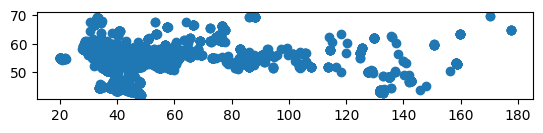

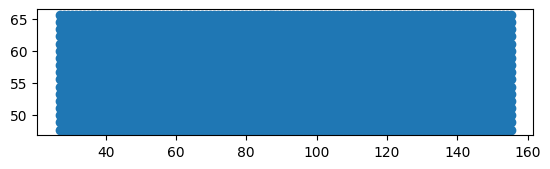

In [24]:
cmap.plot()
points.plot()

In [33]:
cmap_dist = cmap.loc[cmap['distance'] <= 1]
print(f' Number of Companies in range of reference points {cmap_dist.shape[0]} / {cmap.shape[0]}')

 Number of Companies in range of reference points 4286 / 5013


In [42]:
from tqdm import tqdm

def avg_by_time(cmap, rmap):
    nearest_p = cmap['nearest_point'].unique()
    res = np.zeros(nearest_p.shape[0])
    for i in tqdm(range(nearest_p.shape[0])):
        avg_prob = rmap[rmap['geometry'] == nearest_p[i]].prob.mean()
        res[i] = avg_prob
    return nearest_p, res

near_p, prob = avg_by_time(cmap_dist, gdf)

100%|██████████| 326/326 [00:28<00:00, 11.59it/s]


                    geometry  avg_prob
0  POINT (60.75000 56.63509)       0.0
1  POINT (76.50000 65.60686)       0.0
2  POINT (73.12500 61.12099)       0.0
3  POINT (74.25000 62.24246)       0.0
4  POINT (52.87500 54.39214)       0.0


<Axes: >

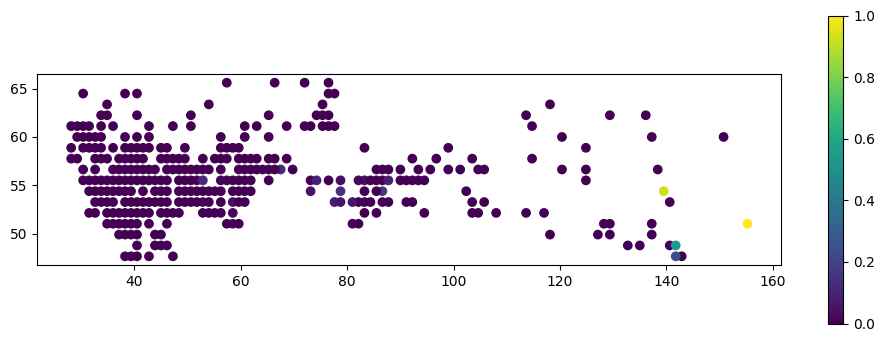

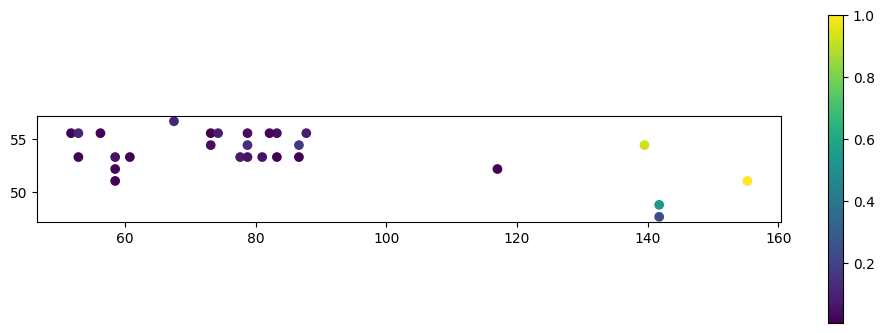

In [49]:
pdf = gpd.GeoDataFrame({'geometry': near_p, 'avg_prob': prob})
print(pdf.head())
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
pdf.plot(column = 'avg_prob', legend=True, ax=ax)
pdf = pdf[pdf['avg_prob'] > 0.0]

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
pdf.plot(column = 'avg_prob', legend=True, ax=ax)